In [930]:
import os
import json
from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from collections import Counter, defaultdict
import cv2
import seaborn as sns
from PIL import Image, ExifTags, ImageDraw
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### TSR Model: CNN

In [931]:
num_classes = 43
real_class = 17

In [932]:
# Transformations for the dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # GTSRB has 43 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
cnn_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cnn = torch.load('model/cnn-real-2024-05-30 16:14:23.497408.pth')

In [933]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # GTSRB has 43 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Output: 32 x 32 x 32
        x = self.pool(torch.relu(self.conv2(x)))  # Output: 64 x 16 x 16
        x = self.pool(torch.relu(self.conv3(x)))  # Output: 128 x 8 x 8
        x = self.pool(torch.relu(self.conv4(x)))  # Output: 256 x 4 x 4
        x = x.view(-1, 256 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

deepcnn = torch.load('model/deepcnn-real-2024-05-30 19:26:16.178286.pth')

In [934]:
resnet_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

resnet = torch.load('model/resnet-real-2024-05-30 17:09:59.869538.pth')

In [935]:
vgg_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

vgg = torch.load('model/vgg-real-2024-05-30 16:25:42.831050.pth')

In [936]:
VIT = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=43, ignore_mismatched_sizes=True)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([43]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([43, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ice1187/car-final/pyenv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [937]:
model_type = 'deepcnn'

if model_type == 'resnet':
    model = resnet
    transform = resnet_transform
elif model_type == 'vgg':
    model = vgg 
    transform = vgg_transform
elif model_type == 'vit':
    print('[!] should not be used!')
    model = VIT
    transform = vit_transform
elif model_type == 'deepcnn':
    model = deepcnn
    transform = cnn_transform
else:
    model = cnn 
    transform = cnn_transform

model.to(device)

DeepCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=43, bias=True)
)

### Evaluation (on Real-World only data)

### Prepare Data
1. Label the bounding box for all Family-Mart 5m 0deg images
2. Use the bounding box info to apply patch
3. Test the attack efficency given difference placement

In [938]:
with open('./data/real-world/processed/FamilyMart/morning/5m/0deg/label.json', 'r') as f:
    label_data = json.load(f)

for i in range(len(label_data)):
    image_url = label_data[i]['image']
    image_path = './data/real-world/processed/' + image_url[image_url.index('?d=')+3:]
    label_data[i]['image'] = image_path
    
print(label_data[0])

{'image': './data/real-world/processed/FamilyMart/morning/5m/0deg/1.jpg', 'id': 133, 'label': [{'x': 4.661654135338346, 'y': 1.0526315789473684, 'width': 74.13533834586465, 'height': 71.42857142857143, 'rotation': 0, 'rectanglelabels': ['no-parking'], 'original_width': 64, 'original_height': 64}], 'annotator': 1, 'annotation_id': 7, 'created_at': '2024-05-30T05:51:53.276644Z', 'updated_at': '2024-05-30T05:51:53.276681Z', 'lead_time': 8.654}


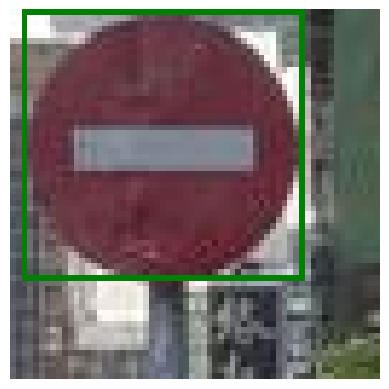

In [939]:
def get_bounding_box(label):
    if type(label) == list:
        label = label[0]
        
    x = label['x'] * label['original_width'] / 100
    y = label['y'] * label['original_height'] / 100
    width = label['width'] * label['original_width'] / 100
    height = label['height'] * label['original_height'] / 100

    x1 = x
    y1 = y
    x2 = x + width
    y2 = y + height
    return (x1, y1, x2, y2), (width, height)

def draw_bounding_boxes(image_path, labels):
    with Image.open(image_path) as image:
        draw = ImageDraw.Draw(image)
    
        for label in labels:
            left, top, right, bottom = get_bounding_box(label)[0]
            draw.rectangle([left, top, right, bottom], outline="green", width=1)
    
            #label_text = label['rectanglelabels'][0]
            #draw.text((left, top - 10), label_text, fill="green")
    
        plt.imshow(image)
        plt.axis('off')
        plt.show()

image_path = label_data[0]['image']
label = label_data[0]['label']
draw_bounding_boxes(image_path, label)

### Attack
- patch size
- patch position
- patch transparency (alpha)

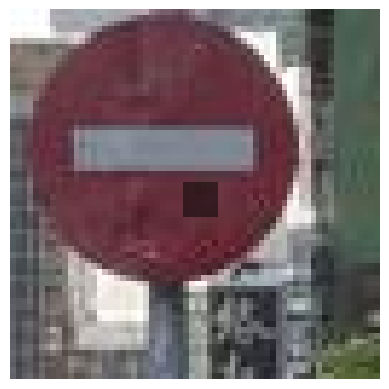

In [940]:
def add_white_rectangle(image, rect_size=(5.0, 5.0), position=(30.0, 30.0), alpha=0.5):
    draw = ImageDraw.Draw(image, 'RGBA')
    rect = [position[0], position[1], position[0] + rect_size[0], position[1] + rect_size[1]]
    white = (0, 0, 0, int(255 * alpha))
    draw.rectangle(rect, fill=white)
    return image

image_path = label_data[0]['image']
label = label_data[0]['label']
with Image.open(image_path) as image:
    image = add_white_rectangle(image)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [941]:
def correct_orientation(image):
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = image._getexif()
        if exif is not None:
            orientation = exif.get(orientation)
            if orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        pass
    return image
    
class InMemoryDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        if self.transform is not None:
            img = self.transform(img)
        label_idx = real_class
        return img, label_idx

# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [942]:
images = []
for label in label_data:
    with open(label['image'], 'rb') as f:
        img = Image.open(f).convert('RGB')
        img = correct_orientation(img)
        images.append(img)
        
orig_dataset = InMemoryDataset(images, transform=transform)
orig_dataloader = DataLoader(orig_dataset, batch_size=32, shuffle=False, num_workers=4)
print(len(orig_dataset), len(orig_dataloader))

44 2


In [943]:
# Evaluation before Attack
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(orig_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {correct / total:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.68it/s]

Accuracy: 100.00%


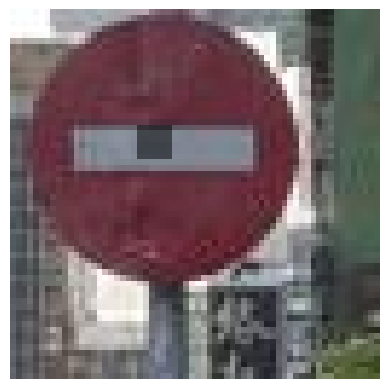

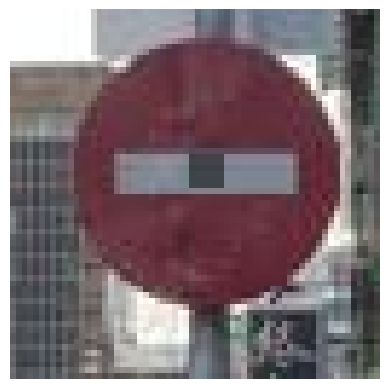

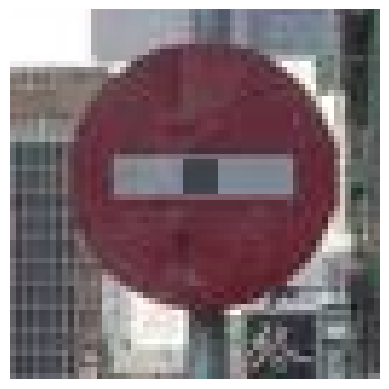

In [944]:
def get_patch_dataloader(pos_fn, size_fn, alpha, demo=0):
    patch_images = []
    for label in label_data:
        image_path = label['image']
        pos, size = get_bounding_box(label['label'])
        pos = pos_fn(pos[0], pos[1], size[0], size[1])
        size = size_fn(size[0], size[1])
        with open(image_path, 'rb') as f:
            patch_img = Image.open(f).convert('RGB')
            patch_img = correct_orientation(patch_img)
            patch_img = add_white_rectangle(
                patch_img,
                position=pos,
                rect_size=size,
                alpha=alpha
            )
            patch_images.append(patch_img)
            
    patch_dataset = InMemoryDataset(patch_images, transform=transform)
    patch_dataloader = DataLoader(patch_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    #print(len(patch_dataset), len(patch_dataloader))
    if demo:
        images = next(iter(patch_dataloader))
        for i in range(demo):
            img = images[0][i]
            demo_image = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize the image for display
            plt.imshow(demo_image)
            plt.axis('off')
            plt.show()
    
    return patch_dataloader

patch_dataloader = get_patch_dataloader(lambda x, y, _, __: (x+20, y+20), lambda w, h: (5, 5), 0.5, demo=3)

In [945]:
# Evaluation after Attack
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(patch_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {correct / total:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]

Accuracy: 100.00%


### Experiments

In [946]:
# NDSS poster steup: 1/10 height, 1/5 width, 1.0 alpha, all place
w_div = 1
h_div = 1

results = []
for i in range(w_div):
    for j in range(h_div):
        pos_fn = lambda x, y, w, h: (x +(w/w_div)*i, y+(h/h_div)*j)
        size_fn = lambda w, h: (w / w_div, h / h_div)
        patch_dataloader = get_patch_dataloader(pos_fn, size_fn, 1.0, demo=0)
        print(i, j)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(patch_dataloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        print(f'Accuracy: {accuracy:.2%}')
        
        results.append((i, j, accuracy))

0 0


100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.93it/s]

Accuracy: 0.00%


best placement: (0, 0, 0.0)


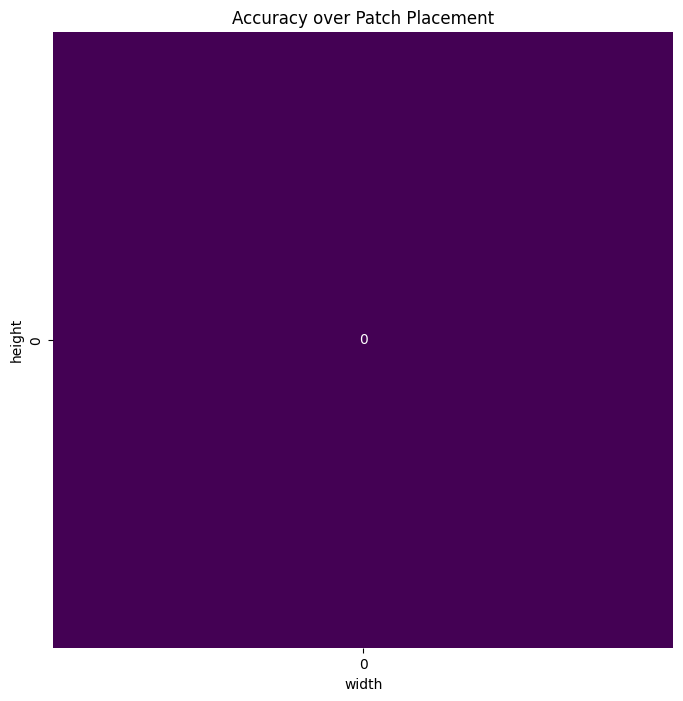

In [947]:
print('best placement:', min(results, key=lambda x: x[2]))

heatmap_data = np.zeros((h_div, w_div))
for x, y, acc in results:
    heatmap_data[y, x] = acc

# Create a heatmap
plt.figure(figsize=(8, 8))
ax = sns.heatmap(heatmap_data, xticklabels=range(w_div), yticklabels=range(h_div), annot=True, cmap='viridis', cbar=False)

ax.set_xlabel('width')
ax.set_ylabel('height')
ax.set_title('Accuracy over Patch Placement')
plt.show()

In [948]:
# alpha with NDSS poster steup best result
best_x, best_y = min(results, key=lambda x: x[2])[:2]
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

print(best_x, best_y)

results = []
for alpha in alphas:
    pos_fn = lambda x, y, w, h: (x +(w/w_div)*best_x, y+(h/h_div)*best_y)
    size_fn = lambda w, h: (w / w_div, h / h_div)
    patch_dataloader = get_patch_dataloader(pos_fn, size_fn, alpha, demo=0)
    print(alpha)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(patch_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.2%}')
    
    results.append((alpha, accuracy))

0 0
0.0


100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.43it/s]


Accuracy: 100.00%
0.2


100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.48it/s]


Accuracy: 100.00%
0.4


100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]


Accuracy: 100.00%
0.6


100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.70it/s]


Accuracy: 100.00%
0.8


100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


Accuracy: 34.09%
1.0


100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.12it/s]

Accuracy: 0.00%


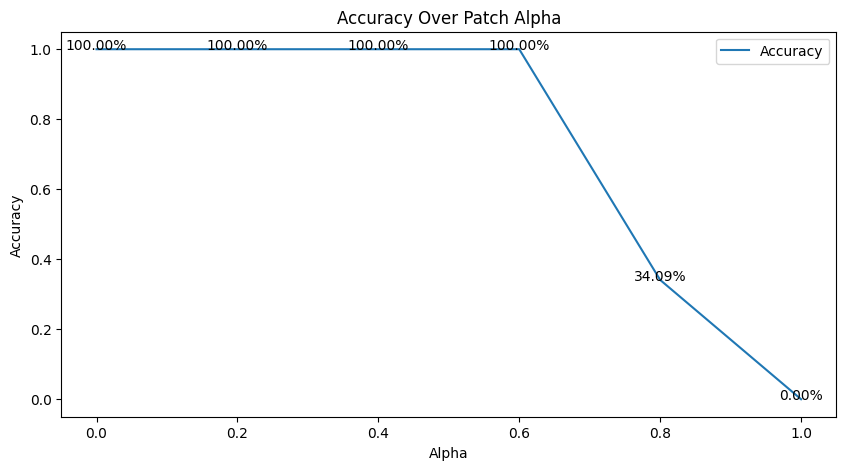

In [949]:
alphas = [r[0] for r in results]
accuracies = [r[1] for r in results]

plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracies, label='Accuracy')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2%}', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,0), ha='center')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Patch Alpha')
plt.legend()
plt.show()